In [1]:
from convokit import Corpus, download
import torch
from torch import nn

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
# from transformers import RobertaModel

corpus = Corpus(filename=download("conversations-gone-awry-corpus"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "DeepPavlov/bert-base-cased-conversational"

/Volumes/Users/tran_s2/.local/lib/python3.11/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


Dataset already exists at /Volumes/Users/tran_s2/.convokit/downloads/conversations-gone-awry-corpus


In [2]:
def loadPairs(corpus, split=None, last_only=False):
    """
    Load context-reply pairs from the Corpus, optionally filtering to only conversations
    from the specified split (train, val, or test).
    Each conversation, which has N comments (not including the section header) will
    get converted into N-1 comment-reply pairs, one pair for each reply
    (the first comment does not reply to anything).
    Each comment-reply pair is a tuple consisting of the conversational context
    (that is, all comments prior to the reply), the reply itself, the label (that
    is, whether the reply contained a derailment event), and the comment ID of the
    reply (for later use in re-joining with the ConvoKit corpus).
    The function returns a list of such pairs.
    """
    pairs = []
    count_attack = 0
    count_convo = 0
    for convo in corpus.iter_conversations():
        # consider only conversations in the specified split of the data
        if split is None or convo.meta['split'] == split:
            count_convo += 1
            utterance_list = []
            for utterance in convo.iter_utterances():
                if utterance.meta['is_section_header']:
                    continue
                if utterance.meta['comment_has_personal_attack']:
                    count_attack += 1
                utterance_list.append({"text": utterance.text, 
                                        "is_attack": int(utterance.meta['comment_has_personal_attack']), 
                                        "id": utterance.id})
                
            iter_range = range(1, len(utterance_list)) if not last_only else [len(utterance_list)-1]
            for idx in iter_range:
                reply = utterance_list[idx]["text"]
                label = utterance_list[idx]["is_attack"]
                comment_id = utterance_list[idx]["id"]
                # gather as context all utterances preceding the reply
                context = [u["text"] for u in utterance_list[idx-2:idx]]
                pairs.append((context, label))

    return pairs

In [3]:
train_pairs = loadPairs(corpus, split='train', last_only=True)
val_pairs = loadPairs(corpus, split='val', last_only=True)

In [4]:
print(len(train_pairs))
print(len(val_pairs))

2508
840


In [5]:
count_pos = 0
single_comment = 0
for i in range(len(train_pairs)):
    # assert len(train_pairs[i][0]) == 2
    if train_pairs[i][1] == 1:
        count_pos += 1
print(single_comment/len(train_pairs), count_pos/len(train_pairs))

0.0 0.5


In [6]:
count_pos = 0
single_comment = 0
for i in range(len(val_pairs)):
    if len(val_pairs[i][0]) != 2:
        single_comment += 1
    if val_pairs[i][1] == 1:
        count_pos += 1
print(single_comment/len(val_pairs), count_pos/len(val_pairs))

0.0 0.5


In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/208k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
import numpy as np
import logging

# By default, the tokenizer will spit out a warning whenever we tokenize a 
# sample which ends up being more than 512 tokens. We don't care about that for
# now, though, and this cell will produce a lot of those warnings! So we'll 
# adjust the logging settings to suppress those warnings and keep the output
# cell cleaner.
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing comments...')
contexts = []
labels = []

# For every sentence...
for context, label in train_pairs:
    # contexts.append(context)
    # labels.append(label)
    # Report progress.
    if ((len(lengths) % 500) == 0):
        print('  Tokenized {:,} comments.'.format(len(lengths)))
    # # print(len(context))
    # # print(*context)
    encoded_sent = tokenizer.encode(*context)
    # print(encoded_sent)

    lengths.append(len(encoded_sent))

print('DONE.')

Tokenizing comments...
  Tokenized 0 comments.
  Tokenized 500 comments.
  Tokenized 1,000 comments.
  Tokenized 1,500 comments.
  Tokenized 2,000 comments.
  Tokenized 2,500 comments.
DONE.


In [9]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 2 tokens
   Max length: 5,409 tokens
Median length: 137 tokens


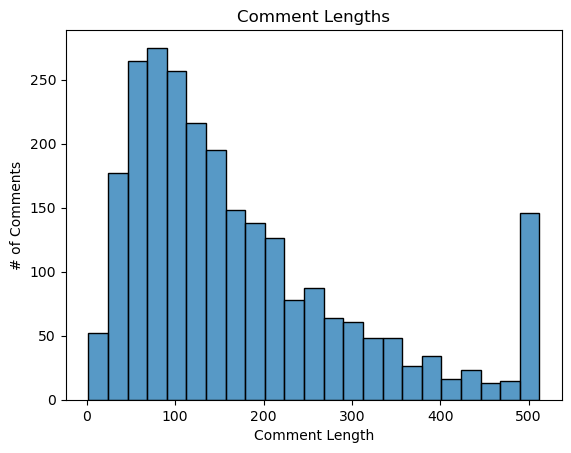

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# sns.set(style='darkgrid')

# Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.histplot(trunc_lengths)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')

plt.show()

In [11]:
import numpy as np

# Cast the list to a numpy array so we can use some numpy features.
lengths = np.asarray(lengths)

# Get the total number of comments.
num_comments = len(lengths)

# Check the following lengths:
max_lens = [128, 256, 300, 400, 512]

print('How many comments will be truncated?\n')

# For each choice...
for max_len in max_lens:

    # Calculate how many comments will be truncacted.
    num_over = np.sum(lengths > max_len)

    # And as a percentage.
    prcnt_over = float(num_over) / float(num_comments)

    print('max_len = {:}  -->  {:>7,} of {:>7,}  ({:>5.1%})  ' \
          'will be truncated '.format(
              max_len, num_over, num_comments, prcnt_over
          ))


How many comments will be truncated?

max_len = 128  -->    1,331 of   2,508  (53.1%)  will be truncated 
max_len = 256  -->      534 of   2,508  (21.3%)  will be truncated 
max_len = 300  -->      406 of   2,508  (16.2%)  will be truncated 
max_len = 400  -->      215 of   2,508  ( 8.6%)  will be truncated 
max_len = 512  -->      131 of   2,508  ( 5.2%)  will be truncated 


In [12]:
# Set our sequence length to pad or truncate all of our samples to.
max_len = 384

In [13]:
from torch.utils.data import DataLoader, TensorDataset
def build_dataloadder(pairs):
    # question = "Is this conversation likely to turn into personal attack?"
    input_ids = []
    attn_masks = []
    labels = []
    print('Encoding {:,} training examples...'.format(len(pairs)))

    # For every training example...
    for context, label in pairs:

        # Report progress.
        if ((len(input_ids) % 500) == 0):
            print('  Encoded {:,} comments.'.format(len(input_ids)))

        # Convert sentence pairs to input IDs, with attention masks.
        encoded_dict = tokenizer.encode_plus(*context,
                                            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                                            max_length=max_len,    # Pad or truncate to this lenght.
                                            pad_to_max_length=True,
                                            truncation=True, 
                                            return_tensors='pt')   # Return objects as PyTorch tensors.

        # Add this example to our lists.
        input_ids.append(encoded_dict['input_ids'])
        attn_masks.append(encoded_dict['attention_mask'])
        labels.append(label)

    # labels = labels.astype(float)
    # Cast the labels list to a 2D Tensor.
    labels = torch.tensor(labels)
    # print(labels.type())
    input_ids = torch.cat(input_ids, dim=0)
    attn_masks = torch.cat(attn_masks, dim=0)
    dataset = TensorDataset(input_ids, attn_masks, labels)
    print('DONE.')
    return DataLoader(dataset, batch_size=16, shuffle=True)

In [14]:
train_dataloader = build_dataloadder(train_pairs)
val_dataloader = build_dataloadder(val_pairs)

Encoding 2,508 training examples...
  Encoded 0 comments.
  Encoded 500 comments.


/Volumes/Users/tran_s2/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  Encoded 1,000 comments.
  Encoded 1,500 comments.
  Encoded 2,000 comments.
  Encoded 2,500 comments.
DONE.
Encoding 840 training examples...
  Encoded 0 comments.
  Encoded 500 comments.
DONE.


In [15]:
from transformers import AutoModelForSequenceClassification, AdamW
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/bert-base-cased-conversational and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/Volumes/Users/tran_s2/.local/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (BERT authors recommend between 2 and 4)
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))  
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [19]:
def calculate_f1_score(labels, preds):
    # preds = torch.sigmoid(logits) > 0.5
    # Calculating precision, recall, and F1 score using PyTorch
    preds = np.argmax(preds, axis=1)
    TP = ((preds == 1) & (labels == 1)).sum().item()
    FP = ((preds == 1) & (labels == 0)).sum().item()
    FN = ((preds == 0) & (labels == 1)).sum().item()

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1
def calculate_accuracy_score(labels, preds):
    preds = np.argmax(preds, axis=1)

    return (labels == preds).sum().item()/labels.shape[0]


In [20]:
def evaluate(model, val_dataloader):
    print("")
    print("Running Validation...")

    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0

    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():   
   

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, attention_mask=b_input_mask, 
                             labels=b_labels)

            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the validation accuracy.
    val_f1 = calculate_f1_score(flat_true_labels, flat_predictions)
    val_acc = calculate_accuracy_score(flat_true_labels, flat_predictions)

    # Report the final accuracy for this validation run.
    print("  F1 Score: {0:.2f}".format(val_f1))
    print("  Accuracy: {0:.2f}".format(val_acc))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

In [21]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    evaluate(model, val_dataloader)
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader), 
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids, attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
 
    

    # # Record all statistics from this epoch.
    # training_stats.append(
    #     {
    #         'epoch': epoch_i + 1,
    #         'Training Loss': avg_train_loss,
    #         'Valid. Loss': avg_val_loss,
    #         'Valid. Accur.': val_acc,
    #         'Training Time': training_time,
    #         'Validation Time': validation_time
    #     }
    # )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Running Validation...
  F1 Score: 0.01
  Accuracy: 0.50
  Validation Loss: 0.71
  Validation took: 0:00:05

======== Epoch 1 / 10 ========
Training...
  Batch    20  of    157.    Elapsed: 0:00:06.
  Batch    40  of    157.    Elapsed: 0:00:11.
  Batch    60  of    157.    Elapsed: 0:00:17.
  Batch    80  of    157.    Elapsed: 0:00:23.
  Batch   100  of    157.    Elapsed: 0:00:28.
  Batch   120  of    157.    Elapsed: 0:00:34.
  Batch   140  of    157.    Elapsed: 0:00:40.

  Average training loss: 0.66
  Training epcoh took: 0:00:45

Running Validation...
  F1 Score: 0.69
  Accuracy: 0.58
  Validation Loss: 0.69
  Validation took: 0:00:05

======== Epoch 2 / 10 ========
Training...
  Batch    20  of    157.    Elapsed: 0:00:06.
  Batch    40  of    157.    Elapsed: 0:00:12.
  Batch    60  of    157.    Elapsed: 0:00:17.
  Batch    80  of    157.    Elapsed: 0:00:23.
  Batch   100  of    157.    Elapsed: 0:00:29.
  Batch   120  of    157.    Elapsed: 0:00:35.
  Batch   140  of    15